<a href="https://colab.research.google.com/github/Eloiseedwards/Assessment-2/blob/main/finBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
from datasets import load_dataset
ds2 = load_dataset("FinGPT/fingpt-sentiment-train", split="train")


In [52]:
mapping_5 = {
    "strong negative": "negative",
    "moderately negative": "moderate_negative",
    "mildly negative": "moderate_negative",
    "negative": "negative",
    "neutral": "neutral",
    "mildly positive": "moderate_positive",
    "moderately positive": "moderate_positive",
    "positive": "positive",
    "strong positive": "positive"
}


In [53]:
def map_to_5(example):
    example["label_5"] = mapping_5[example["output"]]
    return example

ds2 = ds2.map(map_to_5)


In [54]:
unique_new = sorted(list(set(ds2["label_5"])))
id2label = {i: lab for i, lab in enumerate(unique_new)}
label2id = {lab: i for i, lab in id2label.items()}

def encode_label(example):
    example["label"] = label2id[example["label_5"]]
    return example

ds2 = ds2.map(encode_label)


In [55]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
import pandas as pd

# Convert to pandas for easy counting
df = pd.DataFrame(ds2)

# Before mapping (original 9 classes)
print("Original 9-class distribution:")
print(df["output"].value_counts())
print(df["output"].value_counts(normalize=True))

# After mapping (5-class)
print("\nMapped 5-class distribution:")
print(df["label_5"].value_counts())
print(df["label_5"].value_counts(normalize=True))


Original 9-class distribution:
output
neutral                29215
positive               21588
negative               11749
moderately positive     6163
moderately negative     2972
mildly positive         2548
mildly negative         2108
strong negative          218
strong positive          211
Name: count, dtype: int64
output
neutral                0.380542
positive               0.281196
negative               0.153038
moderately positive    0.080277
moderately negative    0.038712
mildly positive        0.033189
mildly negative        0.027458
strong negative        0.002840
strong positive        0.002748
Name: proportion, dtype: float64

Mapped 5-class distribution:
label_5
neutral              29215
positive             21799
negative             11967
moderate_positive     8711
moderate_negative     5080
Name: count, dtype: int64
label_5
neutral              0.380542
positive             0.283945
negative             0.155877
moderate_positive    0.113466
moderate_negative   

In [57]:
def tokenize(batch):
    return tokenizer(batch["input"], truncation=True, padding="max_length", max_length=128)

ds2 = ds2.map(tokenize, batched=True)
ds2 = ds2.train_test_split(test_size=0.2)   # create validation set

ds2 = ds2.remove_columns(["output", "label_5", "input"])  # keep only tokenized fields + label
ds2.set_format("torch")


In [21]:
from transformers import TrainerCallback
import numpy as np

class TrainAccuracyCallback(TrainerCallback):
    def __init__(self):
        self.trainer = None  # Will be set after Trainer initialization

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.trainer is None:
            # This case should ideally not be reached if setup correctly
            raise ValueError("Trainer instance not set in TrainAccuracyCallback.")

        train_ds = self.trainer.train_dataset

        # Get predictions on the training set
        preds_output = self.trainer.predict(train_ds, metric_key_prefix="train")
        logits = preds_output.predictions
        labels = preds_output.label_ids
        preds = np.argmax(logits, axis=1)

        # Compute accuracy
        train_acc = (preds == labels).mean()

        # Log accuracy into trainer history
        self.trainer.state.log_history.append({
            "epoch": state.epoch,
            "train_accuracy": train_acc,
            "step": state.global_step
        })

        print(f"Training Accuracy (epoch {state.epoch:.0f}): {train_acc:.4f}")

In [22]:

from transformers import TrainingArguments, Trainer
import numpy as np
from evaluate import load

metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": metric.compute(predictions=preds, references=labels)["accuracy"]}

training_args = TrainingArguments(
    output_dir="./finbert_5class",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
    report_to="none"
)

# Instantiate the custom callback
train_acc_callback = TrainAccuracyCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds2["train"],
    eval_dataset=ds2["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[train_acc_callback] # Pass the instance here
)

# After the Trainer is initialized, assign the trainer instance to the callback
train_acc_callback.trainer = trainer

trainer.train()

/tmp/ipython-input-1846616030.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.119900,0.297634,0.932139
2,0.115800,0.270553,0.941713
3,0.073100,0.310095,0.942755
4,0.037200,0.355468,0.944448
5,0.013900,0.379104,0.944578


Training Accuracy (epoch 1): 0.9699
Training Accuracy (epoch 2): 0.9875
Training Accuracy (epoch 3): 0.9930
Training Accuracy (epoch 4): 0.9969
Training Accuracy (epoch 5): 0.9982


TrainOutput(global_step=19195, training_loss=0.07681453857113837, metrics={'train_runtime': 3263.5665, 'train_samples_per_second': 94.095, 'train_steps_per_second': 5.882, 'total_flos': 2.019990869463936e+16, 'train_loss': 0.07681453857113837, 'epoch': 5.0})

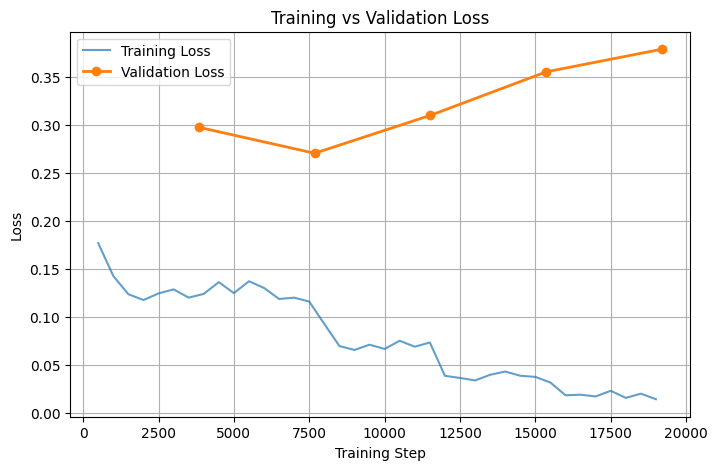

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Load logs
logs = pd.DataFrame(trainer.state.log_history)

train_loss = logs.dropna(subset=["loss"])
eval_loss = logs.dropna(subset=["eval_loss"])

plt.figure(figsize=(8,5))

# Training loss is logged per step
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss", alpha=0.7)

# Validation loss is logged per epoch, so use epoch instead of step
plt.plot(eval_loss["step"], eval_loss["eval_loss"], marker="o", label="Validation Loss", linewidth=2)

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



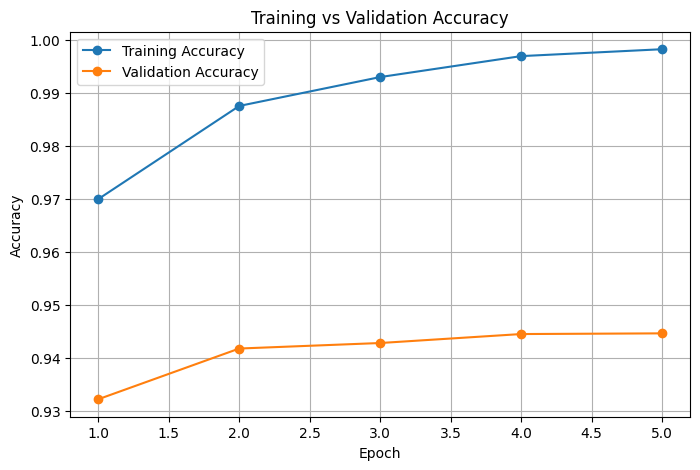

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

train_acc = logs.dropna(subset=["train_accuracy"])
eval_acc = logs.dropna(subset=["eval_accuracy"])

plt.figure(figsize=(8,5))

plt.plot(train_acc["epoch"], train_acc["train_accuracy"], marker="o", label="Training Accuracy")
plt.plot(eval_acc["epoch"], eval_acc["eval_accuracy"], marker="o", label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()



In [25]:
preds = trainer.predict(ds2["test"])
pred_labels = np.argmax(preds.predictions, axis=1)

from sklearn.metrics import classification_report
print(classification_report(preds.label_ids, pred_labels, target_names=list(id2label.values())))


                   precision    recall  f1-score   support

moderate_negative       0.79      0.83      0.81       962
moderate_positive       0.82      0.83      0.83      1729
         negative       0.98      0.97      0.98      2432
          neutral       0.96      0.95      0.96      5880
         positive       0.99      0.99      0.99      4352

         accuracy                           0.94     15355
        macro avg       0.91      0.92      0.91     15355
     weighted avg       0.95      0.94      0.94     15355



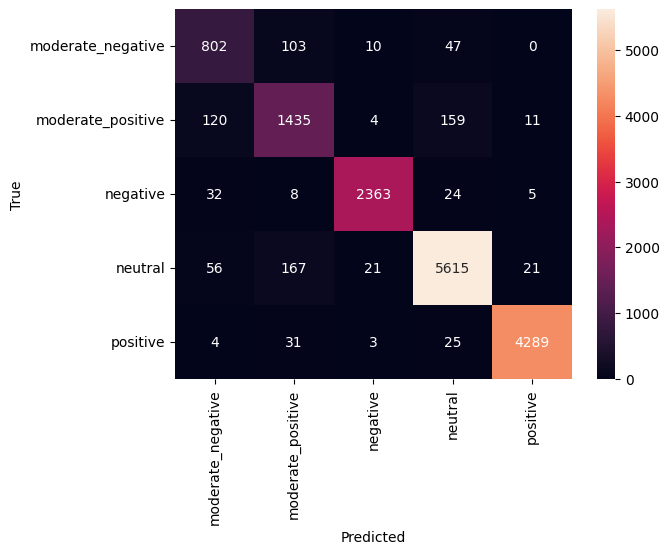

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(preds.label_ids, pred_labels)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [27]:
trainer.save_model("./finbert_5class_model")
tokenizer.save_pretrained("./finbert_5class_model")


('./finbert_5class_model/tokenizer_config.json',
 './finbert_5class_model/special_tokens_map.json',
 './finbert_5class_model/vocab.txt',
 './finbert_5class_model/added_tokens.json',
 './finbert_5class_model/tokenizer.json')

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import numpy as np
from evaluate import load
from torch.nn import CrossEntropyLoss

# ----- Metrics -----
metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": metric.compute(predictions=preds, references=labels)["accuracy"]}

# ----- Freeze lower layers -----
for param in model.bert.encoder.layer[:8].parameters():  # freeze first 8 layers
    param.requires_grad = False

# ----- Adjust dropout -----
model.bert.config.hidden_dropout_prob = 0.2
model.bert.config.attention_probs_dropout_prob = 0.2

# ----- Compute class weights dynamically -----
labels_array = np.array(ds2["train"]["label"])
num_classes = len(np.unique(labels_array))
class_counts = np.bincount(labels_array, minlength=num_classes)
total = labels_array.shape[0]

# Inverse frequency weights
inv_weights = total / (num_classes * class_counts)
class_weights = torch.tensor(inv_weights, dtype=torch.float32).to(model.device)

print("Class weights:", class_weights)

# ----- Weighted Trainer -----
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        # Ensure class_weights is on the same device as logits
        loss_fct = CrossEntropyLoss(weight=class_weights.to(outputs.logits.device))
        loss = loss_fct(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss


# ----- Training arguments for second model -----
second_model_dir = "./finbert_5class_v2"
training_args = TrainingArguments(
    output_dir=second_model_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    warmup_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16=True,
    report_to="none",
    save_total_limit=2,
    load_best_model_at_end=True,       # restore best model automatically
    metric_for_best_model="eval_loss",  # monitor validation loss for early stopping
    greater_is_better=False,            # lower loss is better
    max_grad_norm=1.0                   # gradient clipping
)

# ----- Callbacks -----
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)
callbacks_list = [train_acc_callback, early_stopping]

# ----- Trainer -----
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=ds2["train"],
    eval_dataset=ds2["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=callbacks_list
)

# Assign trainer instance to callback if needed
train_acc_callback.trainer = trainer

# ----- Start training -----
trainer.train()

# ----- Save final trained model separately -----
trainer.save_model(second_model_dir)
tokenizer.save_pretrained(second_model_dir)

print(f"Second FinBERT model saved to {second_model_dir}")



Class weights: tensor([3.0307, 1.7545, 1.2834, 0.5266, 0.7032], device='cuda:0')


/tmp/ipython-input-749070806.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.429000,0.394739,0.875936


Training Accuracy (epoch 1): 0.8944
